# Imports

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import google.colab
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import scipy.stats as stats
from sklearn.feature_selection import f_classif

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
music_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/Music/light_spotify_dataset.csv")

# EDA and cleaning

In [217]:
import re

def normalize_cell(val):
    if isinstance(val, str):
        # Lowercase
        #val = val.lower()
        # Remove leading/trailing spaces
        val = val.strip()
        # Replace multiple spaces inside with a single space
        val = re.sub(r'\s+', ' ', val)
        return val
    else:
        return val  # return numbers unchanged

def normalize_dataframe(df):
    df.columns = [normalize_cell(col) for col in df.columns]
    df.columns = [x.lower() for x in df.columns] # Apply lower to each element of the Index
    df = df.applymap(normalize_cell)
    return df

In [218]:
thirst_rows = music_df[music_df['emotion'] == 'thirst']
pink_rows = music_df[music_df['emotion'] == 'pink']
true_rows = music_df[music_df['emotion'] == 'True']
combined_rows = pd.concat([thirst_rows, pink_rows, true_rows])

df = music_df.copy()
df = df[~df['emotion'].isin(['thirst', 'pink', 'True'])]
df.loc[df['emotion'] == 'angry', 'emotion'] = 'anger'
df.groupby('emotion').size()
df = normalize_dataframe(df)
df = df.dropna()
df = df.drop_duplicates()
top_genres = df['genre'].value_counts().nlargest(11).index
df['genre']=df['genre'].apply(lambda x: x if x in top_genres else 'other')
df['genre']=df['genre'].replace('Unknown,Unknown,Unknown','other')

df['speechiness_log'] = np.log1p(df['speechiness'])
df['instrumentalness_bin'] = (df['instrumentalness'] > 0).astype(int)
df['mode_int'] = df['key'].str.contains('Maj').astype(int)
key_mapping = {'C':0, 'C#':1, 'D':2, 'D#':3, 'E':4, 'F':5, 'F#':6, 'G':7, 'G#':8, 'A':9, 'A#':10, 'B':11}
df['key_root'] = df['key'].str.split().str[0].map(key_mapping)
df['cos_pitch'] = np.cos(2 * np.pi * df['key_root'] / 12)
df['sin_pitch'] = np.sin(2 * np.pi * df['key_root'] / 12)

#print(df['Genre'].value_counts(normalize=True).sum())

<ipython-input-217-cd6ae81b7231>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(normalize_cell)


In [219]:
df.head()

,artist,song,emotion,variance,genre,release date,key,tempo,loudness,explicit,...,speechiness,liveness,acousticness,instrumentalness,speechiness_log,instrumentalness_bin,mode_int,key_root,cos_pitch,sin_pitch
0,ABBA,She's My Kind Of Girl,joy,0.447619,pop,2014,F Maj,128,-6.00,No,...,3,31,7,0,1.386294,0,1,5,-0.866025,0.500000
1,ABBA,"Andante, Andante",love,0.202222,pop,1980,A# Maj,102,-10.72,No,...,2,7,68,0,1.098612,0,1,10,0.500000,-0.866025
2,ABBA,As Good As New,sadness,0.300881,pop,1979,E Maj,139,-5.70,No,...,3,8,20,2,1.386294,1,1,4,-0.500000,0.866025
3,ABBA,Bang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,...,3,32,3,0,1.386294,0,1,5,-0.866025,0.500000
4,ABBA,Bang-A-Boomerang,joy,0.355000,pop,1975,F Maj,132,-3.00,No,...,3,32,3,0,1.386294,0,1,5,-0.866025,0.500000


In [203]:
#df.groupby('genre').size()

In [204]:
'''import pandas as pd
import numpy as np

# Example: assuming your DataFrame is named df and has a column 'key' like "A Maj"
# df = pd.read_csv('your_file.csv')  # if reading from file

# 1️⃣ Split 'key' into 'pitch' and 'mode_str'
df[['pitch', 'mode_str']] = df['key'].str.split(' ', expand=True)

# 2️⃣ Map pitch names to integers (Spotify key values)
pitch_class_map = {
    'C': 0, 'C#': 1, 'D': 2, 'D#': 3, 'E': 4, 'F': 5,
    'F#': 6, 'G': 7, 'G#': 8, 'A': 9, 'A#': 10, 'B': 11
}
df['key_int'] = df['pitch'].map(pitch_class_map)

# 3️⃣ Map mode strings to integers (Spotify mode values)
mode_map = {'Maj': 1, 'min': 0}
df['mode_int'] = df['mode_str'].map(mode_map)

# 4️⃣ Define function for circular encoding of key
def encode_key_circular(key):
    if pd.isna(key):
        return (0.0, 0.0)  # handle missing keys
    angle = 2 * np.pi * key / 12
    return np.cos(angle), np.sin(angle)

# 5️⃣ Apply circular encoding
df['cos_pitch'], df['sin_pitch'] = zip(*df['key_int'].map(encode_key_circular))

# ✅ DONE → final DataFrame now has columns: 'key_int', 'mode_int', 'cos_pitch', 'sin_pitch''''


In [220]:
df.columns

Index(['artist', 'song', 'emotion', 'variance', 'genre', 'release date', 'key', 'tempo', 'loudness', 'explicit', 'popularity', 'energy', 'danceability', 'positiveness', 'speechiness', 'liveness',
       'acousticness', 'instrumentalness', 'speechiness_log', 'instrumentalness_bin', 'mode_int', 'key_root', 'cos_pitch', 'sin_pitch'],
      dtype='object')

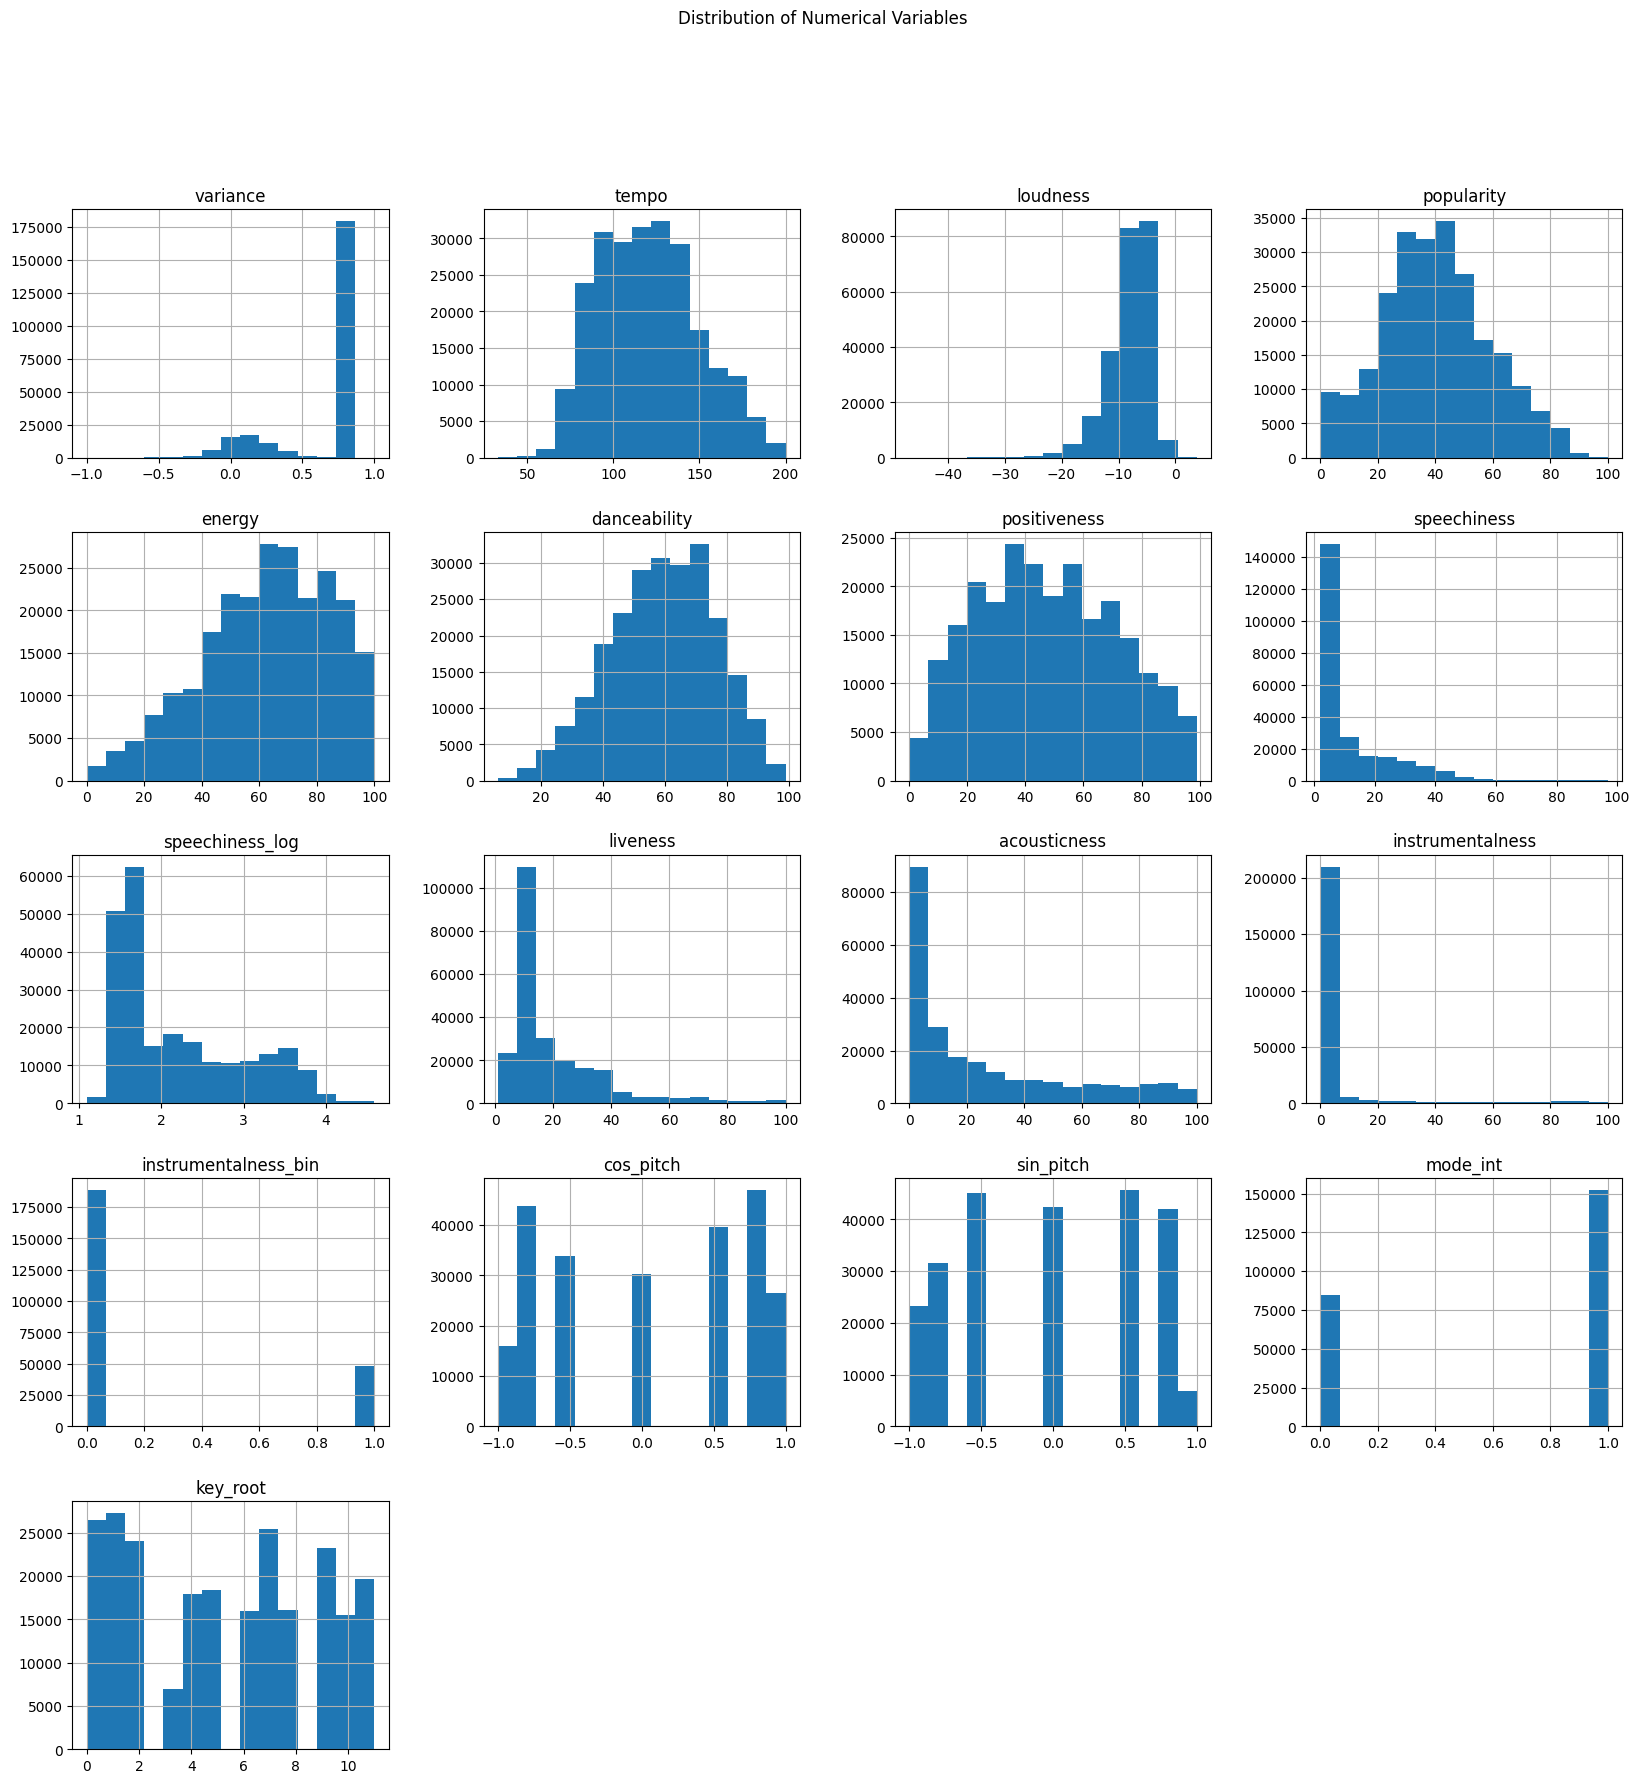

                         count        mean        std        min        25%           50%         75%         max        IQR
variance              236969.0    0.658923   0.320742  -1.000000   0.833514  8.335142e-01    0.833514    1.000000   0.000000
tempo                 236969.0  120.610303  28.966109  33.000000  97.000000  1.200000e+02  140.000000  200.000000  43.000000
loudness              236969.0   -8.038584   3.842136 -46.770000  -9.890000 -7.190000e+00   -5.370000    3.740000   4.520000
popularity            236969.0   40.004203  18.769835   0.000000  27.000000  3.900000e+01   52.000000  100.000000  25.000000
energy                236969.0   62.369027  22.083033   0.000000  48.000000  6.400000e+01   80.000000  100.000000  32.000000
danceability          236969.0   59.128076  17.069227   6.000000  48.000000  6.000000e+01   72.000000   99.000000  24.000000
positiveness          236969.0   47.657601  23.802102   0.000000  29.000000  4.700000e+01   66.000000   99.000000  37.000000


In [225]:
numerical_columns = ['variance','tempo','loudness','popularity','energy','danceability','positiveness','speechiness',
                     'speechiness_log','liveness','acousticness', 'instrumentalness','instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int','key_root']

df[numerical_columns].hist(bins=15, figsize=(20, 20))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

# Get statistical parameters for each numerical feature
stats = df[numerical_columns].describe().T  # Transpose for better readability
# Optional: add IQR (interquartile range) manually
stats['IQR'] = stats['75%'] - stats['25%']
print(stats)

# Frequency of categorical variables
#print()
#print(df['genre'].value_counts())
# Top 10 most frequent artists
#print()
#print(df['artist'].value_counts().head(10))

                         tempo  loudness    energy  danceability  positiveness  speechiness_log  liveness  acousticness  instrumentalness_bin  cos_pitch  sin_pitch  mode_int
tempo                 1.000000  0.116967  0.171032     -0.091356      0.043108         0.053150  0.006788     -0.157458              0.017769   0.018904  -0.008164  0.005402
loudness              0.116967  1.000000  0.747994      0.123130      0.162590         0.166578  0.075841     -0.538370             -0.189521   0.012311  -0.009676 -0.075014
energy                0.171032  0.747994  1.000000      0.023415      0.292641         0.208501  0.171424     -0.665536             -0.015653   0.009507  -0.015991 -0.076767
danceability         -0.091356  0.123130  0.023415      1.000000      0.392165         0.308743 -0.115513     -0.152093             -0.180335   0.041817  -0.017432 -0.087514
positiveness          0.043108  0.162590  0.292641      0.392165      1.000000         0.113265  0.028671     -0.140195           

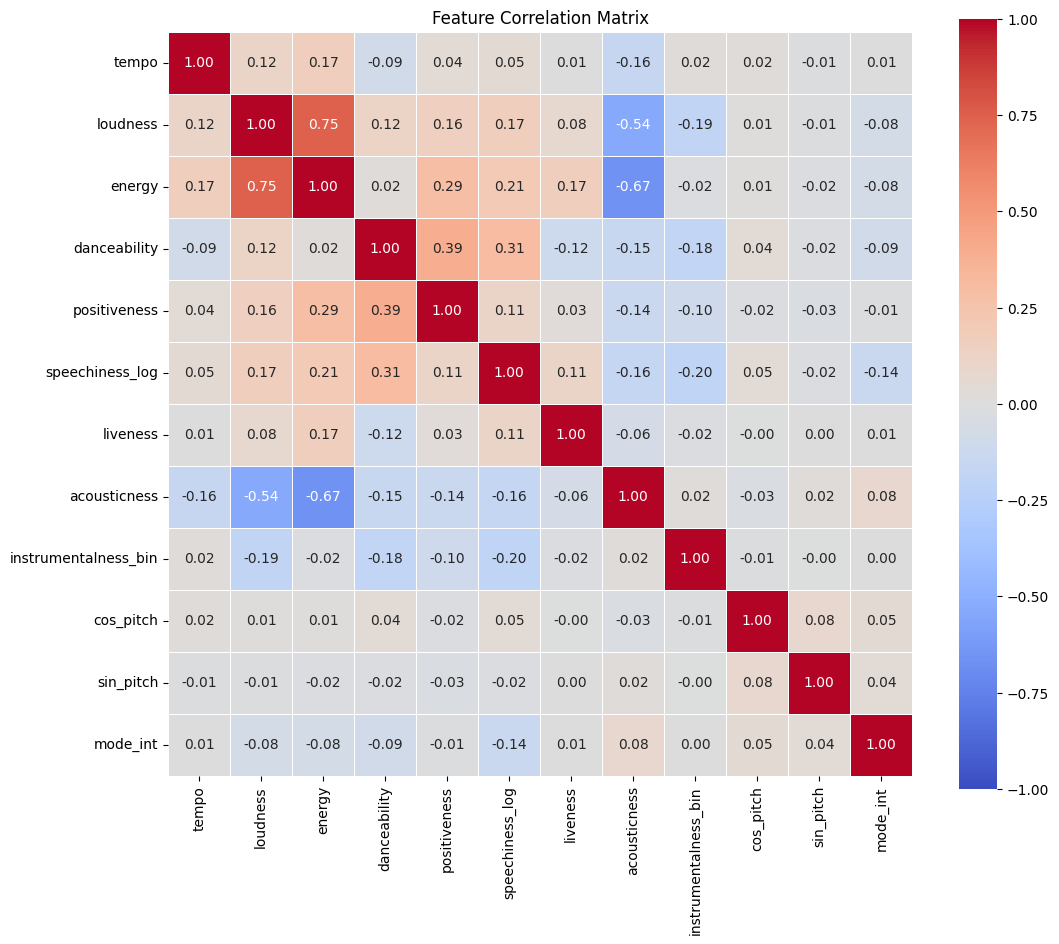

In [228]:
#numerical_columns = ['variance','tempo','loudness','popularity','energy','danceability','positiveness','speechiness',
#                     'speechiness_log','liveness','acousticness', 'instrumentalness','instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int','key_root']
feature_columns = ['tempo','loudness','energy','danceability','positiveness',
                     'speechiness_log','liveness','acousticness','instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int']
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (no need to scale)
corr_matrix = df[feature_columns].corr()

# Display the correlation matrix numerically
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


# Model

In [308]:
from sklearn.model_selection import train_test_split

# Sample 10% of the data
sample_size = 0.05
train_data, test_data = train_test_split(df.sample(frac=sample_size, random_state=42), test_size=0.25, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("Viewing training x_train", train_data.shape)
print("Viewing test test_data", test_data.shape)

# Scale only on train_data
#scaler = StandardScaler()
#scaled_features = scaler.fit_transform(train_data[feature_columns])
#n_samples = scaled_features.shape[0]

Viewing training x_train (8886, 24)
Viewing test test_data (2962, 24)


In [309]:
#!pip install kneed
#!pip install tqdm

In [310]:
'''#!pip install tqdm
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors # Import NearestNeighbors
from kneed import KneeLocator # Import KneeLocator

feature_columns = ['tempo','loudness','energy','danceability','positiveness','speechiness_log',
                     'liveness','acousticness', 'instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int']

feature_weights = np.array([
    1.2,  # tempo
    0.7,  # loudness
    1.3,  # energy
    1.0,  # danceability
    1.2,  # positiveness
    0.6,  # speechiness_log
    0.8,  # liveness
    1.3,  # acousticness
    1.0,  # instrumentalness_bin
    0.9,  # cos_pitch
    0.9,  # sin_pitch
    1.2   # mode_int
])


scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(train_data[feature_columns])
#scaled_features_test = scaler.transform(test_data[feature_columns])

scaled_features_train_weighted = scaled_features_train * feature_weights
n_train_samples = scaled_features_train.shape[0]

# Range of k values to test
k_values = list(range(1, 31))
mean_distances = []

# Progress bar
progress_bar = tqdm(k_values, desc="Starting k testing", unit="k")

# Find optimal k
for idx, k in enumerate(progress_bar, start=1):
    progress_bar.set_description(f"Training k={k} ({idx}/{len(k_values)}) on {n_train_samples} train samples")

    model = NearestNeighbors(n_neighbors=k, metric='cosine')
    model.fit(scaled_features_train)

    distances, indices = model.kneighbors(scaled_features_train)

    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

# Plot mean distance vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_distances, marker='o')
plt.title('Average Distance for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

# Get best k
best_k_min = k_values[np.argmin(mean_distances)]
print(f"Best k (min distance): {best_k_min}")

# Optional: elbow detection
kneedle = KneeLocator(k_values, mean_distances, curve='convex', direction='decreasing')
best_k_elbow = kneedle.knee
print(f"Best k (elbow method): {best_k_elbow}")

# Use elbow if found, else min distance
final_k = best_k_elbow if best_k_elbow else best_k_min

# Train final model on train data
model = NearestNeighbors(n_neighbors=final_k, metric='cosine')
model.fit(scaled_features_train)

# Recommend function (can search train or test song)


# Example recommendation (from test set)'''

'#!pip install tqdm\nfrom tqdm import tqdm\nfrom sklearn.neighbors import NearestNeighbors # Import NearestNeighbors\nfrom kneed import KneeLocator # Import KneeLocator\n\nfeature_columns = [\'tempo\',\'loudness\',\'energy\',\'danceability\',\'positiveness\',\'speechiness_log\',\n                     \'liveness\',\'acousticness\', \'instrumentalness_bin\',\'cos_pitch\', \'sin_pitch\', \'mode_int\']\n                     \nfeature_weights = np.array([\n    1.2,  # tempo\n    0.7,  # loudness\n    1.3,  # energy\n    1.0,  # danceability\n    1.2,  # positiveness\n    0.6,  # speechiness_log\n    0.8,  # liveness\n    1.3,  # acousticness\n    1.0,  # instrumentalness_bin\n    0.9,  # cos_pitch\n    0.9,  # sin_pitch\n    1.2   # mode_int\n])\n\n\nscaler = StandardScaler()\nscaled_features_train = scaler.fit_transform(train_data[feature_columns])\n#scaled_features_test = scaler.transform(test_data[feature_columns])\n\nscaled_features_train_weighted = scaled_features_train * feature_weigh

Training k=30 (30/30) on 8886 samples: 100%|██████████| 30/30 [00:54<00:00,  1.80s/k]


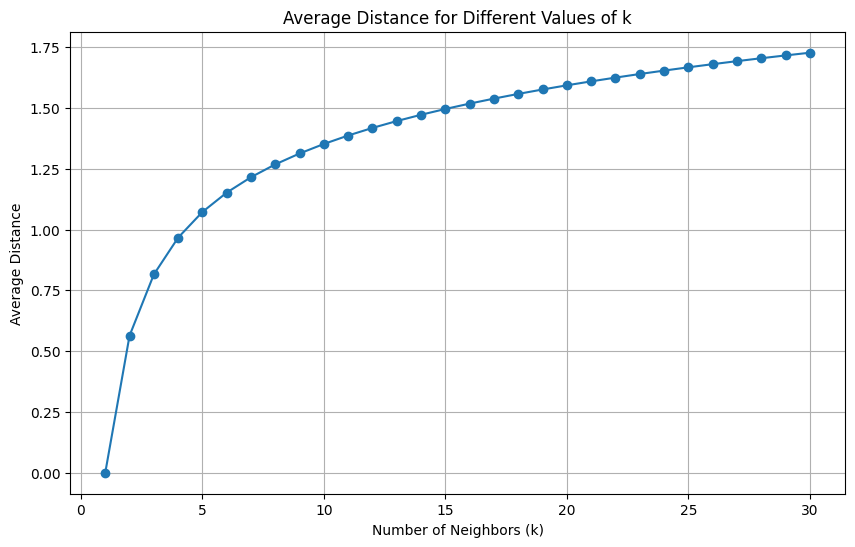

Best k (min distance): 1
Best k (elbow method): 1
Final chosen k: 1


NearestNeighbors(metric='euclidean', n_neighbors=np.int64(1))

In [325]:
#!pip install tqdm kneed
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# --- Feature columns & weights ---
feature_columns = ['tempo','loudness','energy','danceability','positiveness','speechiness_log',
                   'liveness','acousticness', 'instrumentalness_bin','cos_pitch', 'sin_pitch', 'mode_int']

'''feature_weights = np.array([
    1.2,  # tempo
    0.7,  # loudness
    1.3,  # energy
    1.0,  # danceability
    1.2,  # positiveness
    0.6,  # speechiness_log
    0.8,  # liveness
    1.3,  # acousticness
    1.0,  # instrumentalness_bin
    0.9,  # cos_pitch
    0.9,  # sin_pitch
    1.2   # mode_int
])'''
feature_weights = np.ones(len(feature_columns))


# --- Scale features ---
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(train_data[feature_columns])

# --- Apply weights ---
scaled_features_train_weighted = scaled_features_train * feature_weights

n_train_samples = scaled_features_train.shape[0]

# --- Range of k values ---
k_values = list(range(1, 31))
mean_distances = []

progress_bar = tqdm(k_values, desc="Starting k testing", unit="k")

# --- Evaluate different k ---
for idx, k in enumerate(progress_bar, start=1):
    progress_bar.set_description(f"Training k={k} ({idx}/{len(k_values)}) on {n_train_samples} samples")

    model = NearestNeighbors(n_neighbors=k, metric='euclidean')
    model.fit(scaled_features_train_weighted)

    distances, indices = model.kneighbors(scaled_features_train_weighted)

    mean_distance = np.mean(distances)
    mean_distances.append(mean_distance)

# --- Plot mean distance vs k ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_distances, marker='o')
plt.title('Average Distance for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average Distance')
plt.grid(True)
plt.show()

# --- Find best k ---
best_k_min = k_values[np.argmin(mean_distances)]
print(f"Best k (min distance): {best_k_min}")

# --- Optional: elbow detection ---
kneedle = KneeLocator(k_values, mean_distances, curve='convex', direction='decreasing')
best_k_elbow = kneedle.knee
print(f"Best k (elbow method): {best_k_elbow}")

final_k = best_k_elbow if best_k_elbow else best_k_min
print(f"Final chosen k: {final_k}")

# --- Train final model ---
final_model = NearestNeighbors(n_neighbors=final_k, metric='euclidean')
final_model.fit(scaled_features_train_weighted)

In [326]:
final_model = NearestNeighbors(n_neighbors=6, metric='euclidean')
final_model.fit(scaled_features_train_weighted)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [337]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
reduced_features_train = pca.fit_transform(scaled_features_train_weighted)



🔍 Top contributing features in PC1:
energy                  0.531868
loudness                0.501917
acousticness            0.471743
positiveness            0.273152
speechiness_log         0.258382
danceability            0.216342
instrumentalness_bin    0.133736
tempo                   0.128404
mode_int                0.102980
liveness                0.086892
sin_pitch               0.034502
cos_pitch               0.027535
Name: PC1, dtype: float64


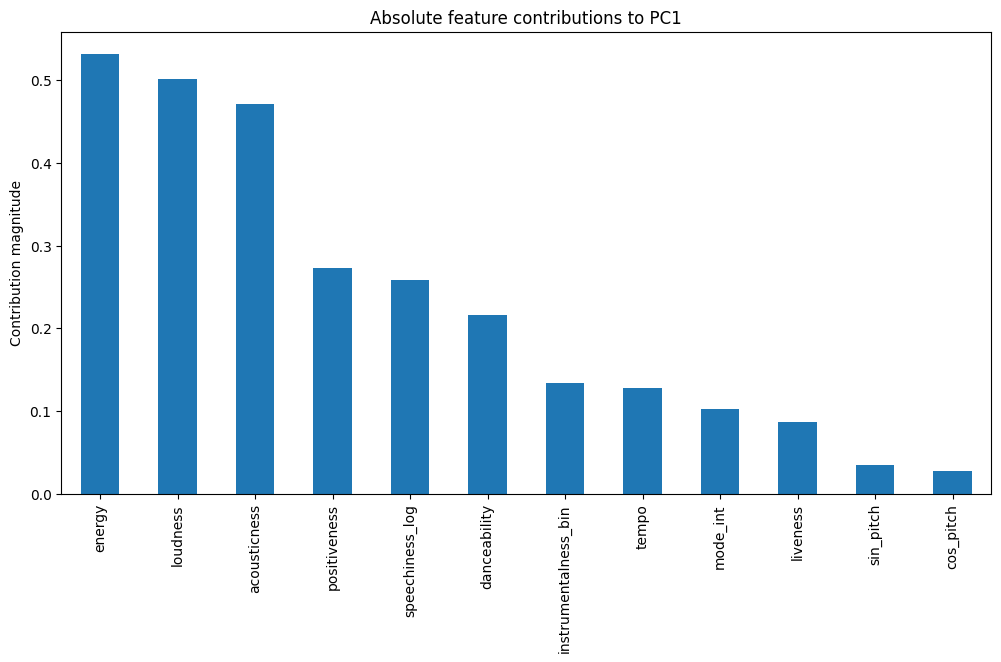


Explained variance ratio per component:
[0.221 0.124 0.094 0.09  0.084 0.081 0.077 0.075 0.062 0.045 0.034 0.014]


In [339]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use your weighted & scaled feature matrix
X = scaled_features_train_weighted  # or unweighted if you want
feature_names = feature_columns

# 1️⃣ Fit PCA
pca = PCA(n_components=len(feature_names))
pca.fit(X)

# 2️⃣ Get loadings
loadings = pca.components_.T  # shape: (features, PCs)

# 3️⃣ Create DataFrame for easier viewing
loadings_df = pd.DataFrame(loadings, index=feature_names,
                           columns=[f'PC{i+1}' for i in range(loadings.shape[1])])

# 4️⃣ Show absolute contribution in first principal component
abs_loadings = loadings_df['PC1'].abs().sort_values(ascending=False)
print("\n🔍 Top contributing features in PC1:")
print(abs_loadings)

# 5️⃣ Optional: plot contributions
abs_loadings.plot(kind='bar', figsize=(12,6))
plt.title('Absolute feature contributions to PC1')
plt.ylabel('Contribution magnitude')
plt.show()

# 6️⃣ (Optional) Print explained variance
print("\nExplained variance ratio per component:")
print(np.round(pca.explained_variance_ratio_, 3))


# Artists Handelling

In [327]:
#!pip install transformers
#!pip install torch
#!pip install gensim
#!pip install requests

In [328]:
import requests
from collections import Counter
import json

def get_artist_id(artist_name):
    url = f"https://api.deezer.com/search/artist?q={artist_name}"
    response = requests.get(url)
    data = response.json()
    if data['data']:
        return data['data'][0]['id']
    return None

def get_similar_artists(artist_id):
    url = f"https://api.deezer.com/artist/{artist_id}/related"
    response = requests.get(url)
    data = response.json()
    return [artist['name'] for artist in data['data']]

def recommend_artists(favorite_artists, save_to_file=False):
    all_similar = []

    for name in favorite_artists:
        artist_id = get_artist_id(name)
        if artist_id:
            print(f"Found artist: {name} — fetching similar artists...")
            similar = get_similar_artists(artist_id)
            all_similar.extend(similar)
        else:
            print(f"Could not find artist: {name}")

    recommended = Counter(all_similar)

    # Filter out any artists already in favorites
    recommended = {
        artist: count for artist, count in recommended.items()
        if artist not in favorite_artists
    }

    if save_to_file:
        with open("recommended_artists.json", "w") as f:
            json.dump(recommended, f, indent=2)

    return recommended

# === Example Usage ===
'''favorite_artists = [
    "The Beatles",
    "Coldplay",
    "Arctic Monkeys",
    "Elton John",
    "Polo & Pan"
]'''


#print("\nTop recommended artists with scores:")
#for artist, score in sorted(recommendations.items(), key=lambda x: x[1], reverse=True):
#    print(f"- {artist}: {score}")

'favorite_artists = [\n    "The Beatles",\n    "Coldplay",\n    "Arctic Monkeys",\n    "Elton John",\n    "Polo & Pan"\n]'

In [329]:
from collections import deque

def expand_artist_dict_with_degree(base_artists, max_degree=2, max_related_per_artist=3):
    expanded = dict(base_artists)  # original dict: {artist_name: score}
    visited = set(base_artists.keys())
    queue = deque([(artist, 1) for artist in base_artists.keys()])  # (artist, current_degree)

    while queue:
        current_artist, degree = queue.popleft()

        if degree > max_degree:
            continue

        artist_id = get_artist_id(current_artist)
        if not artist_id:
            continue

        related_artists = get_similar_artists(artist_id)[:max_related_per_artist]

        for related in related_artists:
            if related not in visited:
                visited.add(related)
                score = max(1, base_artists.get(current_artist, 1) - degree + 1)
                expanded[related] = score
                queue.append((related, degree + 1))

    return expanded

# Recomendation

In [330]:
def recommend_from_favorite_artists(artist_name, song_name, artist_score_dict,
                                    dataset='train', num_recommendations=15,
                                    query_n_neighbors=None):
    """
    Recommend songs from favorite artists using a pre-trained final_model.
    Filters neighbors to only include preferred artists without retraining the model.
    ALSO prints the top global nearest neighbors BEFORE filtering.
    """
    # 1️⃣ Select dataset
    if dataset == 'test':
        query_data = test_data
        features_data = scaled_features_test
    elif dataset == 'train':
        query_data = train_data
        features_data = scaled_features_train
    elif dataset == 'all':
        query_data = df.reset_index(drop=True)
        features_data = scaler.transform(df[feature_columns])
    else:
        print("Invalid dataset.")
        return

    # 2️⃣ Find song index
    song_idx = query_data[
        (query_data['artist'].str.lower() == artist_name.lower()) &
        (query_data['song'].str.lower() == song_name.lower())
    ].index

    if len(song_idx) == 0:
        print("Song not found.")
        return

    song_idx = query_data.index.get_loc(song_idx[0])

    # 3️⃣ Prepare query vector (scale + weight)
    query_vector = features_data[song_idx] * feature_weights

    # 4️⃣ Query final_model for neighbors
    n_query = query_n_neighbors if query_n_neighbors else final_model.n_neighbors
    n_query = min(n_query, len(train_data))  # cap to available samples
    distances, indices = final_model.kneighbors([query_vector], n_neighbors=n_query)

    # 5️⃣ Map indices to train_data → **all neighbors BEFORE filtering**
    all_neighbors_df = train_data.iloc[indices[0]].copy()
    all_neighbors_df['distance'] = distances[0]
    all_neighbors_df['score'] = 1 / (1 + all_neighbors_df['distance'])

    # 🔍 ✅ Print debug: top 5 global neighbors before filtering
    print("\n🔥 Top 5 nearest neighbors globally (before filtering):")
    print(all_neighbors_df[['artist', 'song', 'score']].head())

    # 6️⃣ Filter to only favorite artists
    filtered_neighbors = all_neighbors_df[all_neighbors_df['artist'].isin(artist_score_dict.keys())].copy()

    if filtered_neighbors.empty:
        print("No neighbors from preferred artists found.")
        return filtered_neighbors

    # 7️⃣ Compute similarity score (already in 'score' column)
    # Apply boost
    boosts = filtered_neighbors['artist'].map(artist_score_dict)
    filtered_neighbors['boosted_score'] = filtered_neighbors['score'] + boosts * 0.1

    # 8️⃣ Sort and return top N
    filtered_neighbors = filtered_neighbors.sort_values(by='boosted_score', ascending=False).head(num_recommendations)

    return filtered_neighbors[['artist', 'song', 'genre', 'emotion', 'score', 'boosted_score']]


In [331]:
def iterative_recommendation(artist_name, song_name, base_artist_dict,
                             dataset='all', num_recommendations=5,
                             min_score_threshold=0.89, max_degree_limit=3):
    """
    Iteratively recommend songs, prioritizing preferred artists.
    Includes input artist automatically.
    Falls back to global recommendations if no preferred artist exceeds threshold.
    """
    # ✅ Ensure input artist included
    if artist_name not in base_artist_dict:
        base_artist_dict[artist_name] = 1  # assign default boost
        print(f"👋 Added input artist '{artist_name}' to artist dictionary.")

    current_artist_dict = dict(base_artist_dict)
    degree = 1
    recommendations = None

    print("=" * 50)
    print(f"Starting iterative recommendation for: {artist_name} - {song_name}")
    print(f"Initial artist dict: {list(current_artist_dict.keys())}")
    print("=" * 50)

    while degree <= max_degree_limit:
        print("\n" + "-" * 50)
        print(f"Attempt at degree {degree}")
        print(f"Number of artists in artist dict: {len(current_artist_dict)}")
        print(f"Artist dict contents: {current_artist_dict}")

        recommendations = recommend_from_favorite_artists(
            artist_name, song_name, current_artist_dict,
            dataset=dataset, num_recommendations=num_recommendations,
            query_n_neighbors=200  # query more neighbors to ensure enough after filtering
        )

        if recommendations is None:
            print("No recommendations returned (function returned None).")
            degree += 1
            continue
        elif recommendations.empty:
            print("Recommendations returned but empty DataFrame.")
            degree += 1
            continue
        else:
            print("\nRecommendations received:")
            print(recommendations)

        # ✅ Remove same song+artist from recommendations
        mask_same_song = (
            (recommendations['artist'].str.lower() == artist_name.lower()) &
            (recommendations['song'].str.lower() == song_name.lower()))
        recommendations.loc[mask_same_song, 'score'] = 0
        recommendations = recommendations[~mask_same_song]
        print(f"Removed same song+artist from recommendations.")

        if recommendations.empty:
            print("⚠️ No recommendations left after filtering same song+artist.")
            degree += 1
            continue

        max_score = recommendations['score'].max()
        print(f"\nMax similarity score in recommendations: {max_score:.4f}")

        if max_score >= min_score_threshold:
            print(f"\n✅ Acceptable recommendation found with score {max_score:.4f}.")
            return recommendations

        # ✅ If reached max degree → fallback to any artist
        if degree == max_degree_limit:
            print(f"\n🚩 Max degree {max_degree_limit} reached and no recommendation met threshold {min_score_threshold}.")
            print("🔔 Returning fallback recommendations from ANY artist (no artist filter).")

            fallback_recommendations = recommend_from_favorite_artists(
                artist_name, song_name,
                artist_score_dict={},  # disables filtering → recommend from all artists
                dataset=dataset,
                num_recommendations=num_recommendations,
                query_n_neighbors=200
            )
            return fallback_recommendations

        # ✅ Expand artist dict for next iteration
        print(f"\n❌ Score {max_score:.4f} below threshold {min_score_threshold}. Expanding artist dict...")

        current_artist_dict = expand_artist_dict_with_degree(
            base_artists=current_artist_dict,
            max_degree=degree + 1,
            max_related_per_artist=3
        )
        print(f"Expanded artist dict to {len(current_artist_dict)} artists: {list(current_artist_dict.keys())}")

        degree += 1

    # Should never get here, fallback already handled inside loop
    return recommendations


# Test

In [332]:
# Get user input
artist_input = input("Enter your favorite artists (comma-separated): ")
#genre_input = input("Enter your favorite genres (comma-separated): ")
artist_list = artist_input.split(',')
#genre_list = genre_input.split(',')

Enter your favorite artists (comma-separated): Taylor Swift


In [333]:
closest = recommend_artists(artist_list, save_to_file=True)
'''expanded_dict = expand_artist_dict_with_degree(
    base_artists=favorite_artists,
    max_degree=1,
    max_related_per_artist=1
)'''

Found artist: Taylor Swift — fetching similar artists...


'expanded_dict = expand_artist_dict_with_degree(\n    base_artists=favorite_artists,\n    max_degree=1,\n    max_related_per_artist=1\n)'

In [334]:
print(closest)

{'Gracie Abrams': 1, 'Olivia Rodrigo': 1, 'Sabrina Carpenter': 1, 'Shawn Mendes': 1, 'One Direction': 1, 'Miley Cyrus': 1, 'Harry Styles': 1, 'Camila Cabello': 1, 'Little Mix': 1, 'Katy Perry': 1, 'Adele': 1, 'Ed Sheeran': 1, 'Zara Larsson': 1, 'Sam Smith': 1, 'Niall Horan': 1, 'Halsey': 1, 'Maisie Peters': 1, 'Ariana Grande': 1, 'Selena Gomez': 1, 'Meghan Trainor': 1}


In [335]:
print(len(closest))

20


In [336]:
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
#recommended = iterative_recommendation("Olivia Rodrigo", 'deja vu', closest, dataset='all',num_recommendations=10,0.89,3)
result = iterative_recommendation(
    artist_name="Ariana Grande",
    song_name="Into You",
    base_artist_dict=closest,
    dataset="all",
    num_recommendations=5,
    min_score_threshold=0.89,
    max_degree_limit=3
)


Starting iterative recommendation for: Ariana Grande - Into You
Initial artist dict: ['Gracie Abrams', 'Olivia Rodrigo', 'Sabrina Carpenter', 'Shawn Mendes', 'One Direction', 'Miley Cyrus', 'Harry Styles', 'Camila Cabello', 'Little Mix', 'Katy Perry', 'Adele', 'Ed Sheeran', 'Zara Larsson', 'Sam Smith', 'Niall Horan', 'Halsey', 'Maisie Peters', 'Ariana Grande', 'Selena Gomez', 'Meghan Trainor']

--------------------------------------------------
Attempt at degree 1
Number of artists in artist dict: 20
Artist dict contents: {'Gracie Abrams': 1, 'Olivia Rodrigo': 1, 'Sabrina Carpenter': 1, 'Shawn Mendes': 1, 'One Direction': 1, 'Miley Cyrus': 1, 'Harry Styles': 1, 'Camila Cabello': 1, 'Little Mix': 1, 'Katy Perry': 1, 'Adele': 1, 'Ed Sheeran': 1, 'Zara Larsson': 1, 'Sam Smith': 1, 'Niall Horan': 1, 'Halsey': 1, 'Maisie Peters': 1, 'Ariana Grande': 1, 'Selena Gomez': 1, 'Meghan Trainor': 1}

🔥 Top 5 nearest neighbors globally (before filtering):
               artist        song     score


In [262]:
print(recommended)

None


In [ ]:
while True:
    print("\n--- Music Recommender ---")
    artist = input("Enter artist name (or 'quit' to exit): ").strip()
    if artist.lower() == 'quit':
        print("Exiting recommendation system.")
        break

    song = input("Enter song name: ").strip()
    dataset = input("Search in which dataset? ('train', 'test', 'all'): ").strip().lower()

    recommended = recommend_songs(artist, song, dataset=dataset)

    if recommended is not None:
        print(f"Recommendations similar to '{song}' by {artist}:")
        print(recommended)



--- Music Recommender ---
Enter artist name (or 'quit' to exit): quit
Exiting recommendation system.
